In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import glob

plt.rcParams["axes.linewidth"]  = 1.0
plt.rcParams["xtick.major.size"]  = 10
plt.rcParams["xtick.minor.size"]  = 5
plt.rcParams["ytick.major.size"]  = 10
plt.rcParams["ytick.minor.size"]  = 5
plt.rcParams["xtick.direction"]  = "in"
plt.rcParams["ytick.direction"]  = "in"
plt.rcParams["legend.frameon"] = 'False'
plt.rcParams['figure.figsize'] = [10, 10]
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=22)

import os
if os.environ['USER'] == 'dhayaa':
    os.environ['PATH'] = f"{os.environ['PATH']}:/software/texlive-2021-el7-x86_64/bin/x86_64-linux"
    
    
COLORS = ["f07167","219ebc","c767ac", "59a270", "ffba0a"]
COLORS = ['#' + c if c[0] != '#' else c for c in COLORS ]

from cycler import cycler

# Update the default prop_cycle
plt.rcParams['axes.prop_cycle'] = cycler(color=COLORS)

In [3]:
min_z   = 0.01
max_z   = 5
delta_z = 0.05
zbins   = np.arange(min_z,max_z+delta_z,delta_z)
zbinsc  = zbins[:-1]+(zbins[1]-zbins[0])/2.


files = sorted(glob.glob('/project/chihway/dhayaa/DECADE/SOMPZ/Runs/20240408/Final/nz_Samp*.npy'))
X  = np.concatenate([np.load(f)[::] for f in files]); print(X.shape)
X  = X[np.random.choice(X.shape[0], 10_000, replace = False)]; print(X.shape)

mean = np.trapz(X * zbinsc[None, None, :], zbinsc, axis = -1)/np.trapz(X, zbinsc, axis = -1)
mask = (zbinsc > 0) & (zbinsc < 2.0)
X = np.sort(X, axis = 0)
X = X[int(X.shape[0] * 0.025) : int(X.shape[0] * 0.975)]


colors2 =['C0', 'C1', 'C2', 'C3']


Z  = np.load('/project/chihway/dhayaa/DECADE/Wz/20240726_fiducial_Wz_600patch_urmask_CovMat.npy', allow_pickle = True)[()]
z = np.linspace(0.1, 2.1, 40 + 1)
z = (z[1:] + z[:-1])/2

dz1 = delta_z
dz3 = z[1] - z[0]

(4000000, 4, 100)
(10000, 4, 100)


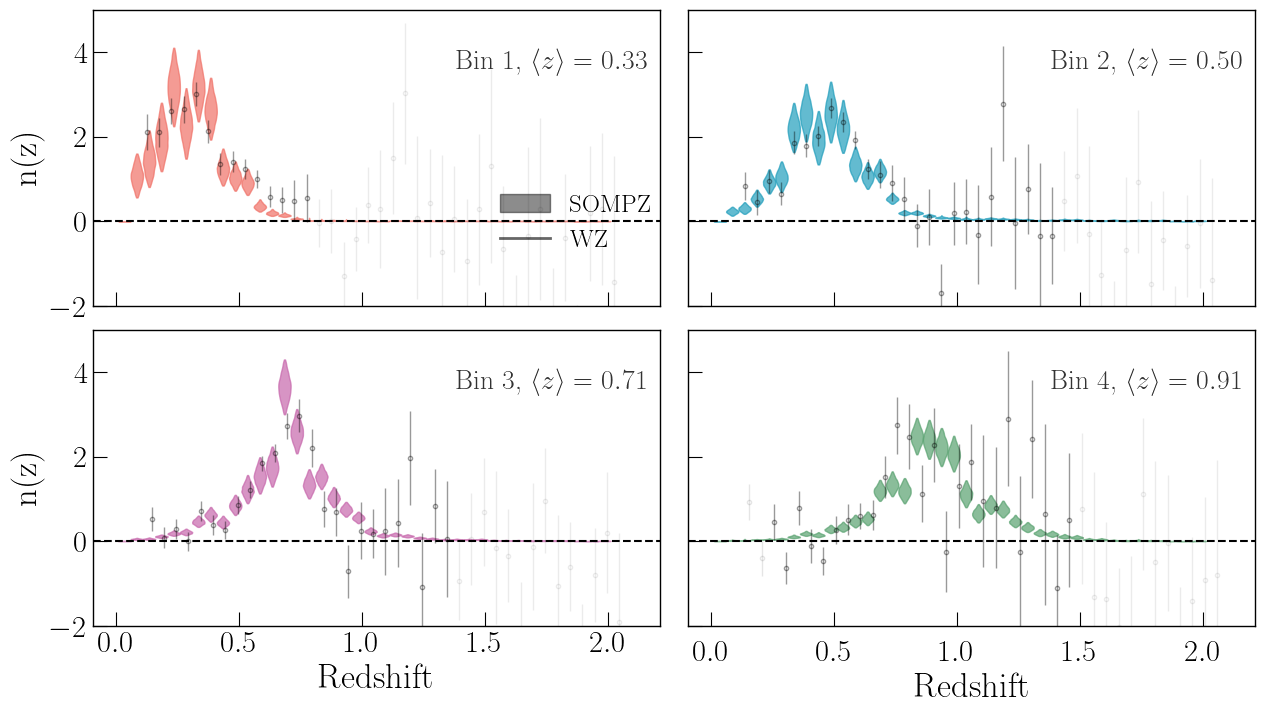

In [24]:
fig, ax = plt.subplots(2, 2, sharex = True, sharey = True, figsize = (15,  8))
ax = ax.flatten()
plt.subplots_adjust(wspace = 0.05, hspace = 0.08)


f = [0.9, 0.7, 0.6, 0.7]
for i in range(4):
    
    nz_here = np.mean(X[:,i, mask], axis = 0)
    cdf     = np.cumsum(nz_here)/np.sum(nz_here)
    cdf[-1] = 1
    
    for j in range(Z['N_z'][i].size):
        
#         if z[j] > 1.3: break
        
        a = 1 - 1.5*Z['dN_z'][i][j]/np.max(Z['dN_z'][i])
        c = cdf[np.argmin(np.abs(z[j] - zbinsc[mask]))]
        
        if c < 0.005:
            a = 0.1
        elif c > 0.99:
            a = 0.08
        else:
            a = 0.4
        
        ax[i].errorbar(z[j] + 0.01*i, f[i]*Z['N_z'][i][j] / np.sqrt(dz3), yerr = f[i]*Z['dN_z'][i][j] / np.sqrt(dz3), elinewidth = 1, 
                       lw = 0, color  = 'k', alpha = a, zorder = 1000, marker = 'o', markersize = 3, markeredgecolor = 'k', markerfacecolor = 'none')
    
    parts2 = ax[i].violinplot(X[:,i, mask] / dz1,positions=zbinsc[mask],
                              widths=0.05, showmeans=False, showmedians=False, showextrema=False, )
    for pc in parts2['bodies']:
        pc.set_facecolor(colors2[i])
        pc.set_edgecolor(colors2[i])
        pc.set_alpha(0.7)
    

[a.axhline(0, color =  'k', ls = '--') for a in ax.flat]
[a.set_xlabel('Redshift', size = 25) for a in ax[2:].flat]
ax[0].set_ylabel('n(z)', size = 25)
ax[2].set_ylabel('n(z)', size = 25)

# ax[0].set_xticks([0,  0.5, 1.0, 1.5, 2.0])
# ax[0].set_xticklabels([0,  0.5, 1.0, 1.5, 2.0])

[a.text(0.64, 0.8, r'Bin %d, $\langle z \rangle = %0.2f$' % (i + 1, np.median(mean[:, i])), 
        size = 20, transform = a.transAxes, color = 'k', alpha = 0.8) 
 for i, a in enumerate(ax.flatten())]


ax[0].legend([plt.fill_between([], [], alpha = 0.45, color = 'k'),
              plt.errorbar([], [],yerr = [], color = 'k', alpha = 0.6, lw = 2)[0], ],
             ['SOMPZ', 'WZ'], fontsize = 18, loc = (0.7, 0.15))

plt.ylim(-2, 5)
plt.tick_params(which = 'both', pad = 10)
plt.savefig('./nofz_fid.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()